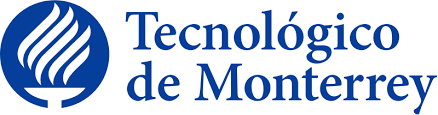

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Procesamiento de Lenguaje Natural (NLP)**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Actividad en Equipos - Semana 9: Traducciones y clasificación de textos**

###**Equipo 5:**

###**A01748750 - Evelyn Aylin Rendón Medina**
###**A01002111 - Luis Salvador Cruz Najera**
###**A01169213 - Laura Elena Hernández Mata**
###**A01793052 - Juan Carlos Lopez Cruz**
###**A01793054 - Rafael José Mateo Comprés**


#**Actividad en Equipos - Semana 5:**

En la actividad de esta semana trabajarás en equipos mediante el uso de Transformers.

HuggingFace (HF) es una plataforma de una comunidad de IA que promueve las contribuciones de código
abierto, en particular para compartir modelos de aprendizaje profundo, entre ellos los Transformers o modelos basados en el mecanismo de Attention: https://huggingface.co/

La plataforma de HF está muy bien documentada, es de acceso abierto, pero deberás generar una cuenta sin costo para su uso. En ocasiones deberás generar una clave para el uso de algunos modelos, pero es solo para el control del uso de dicha plataforma y no generan algún costo para su uso educativo o de investigación, al menos hasta ahora.

En particular en esta actividad estarás usando varios de los modelos Transformer que hacen tareas diversas, tanto en inglés como en español. El objetivo es que te familiarices con dicha plataforma y experimentes posteriormente con ella para las tareas o problemáticas particulares que te interesen.

# **Actividades:**

###1.- Descarga el archivo amazonbaby5000.csv que se encuentra en Canvas. Este archivo está formado de comentarios en inglés sobre productos para bebé adquiridos en la plataforma de Amazon.###

In [306]:
import pandas as pd
import numpy as np
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split

In [307]:
df = pd.read_csv("https://raw.githubusercontent.com/luiscruzn/data/main/amazonbaby5000.csv", encoding='utf-8')

df.rename(columns={'rating': 'labels'}, inplace=True)

df.head()


,review,labels
0,I think it is more Expensive than drugstore th...,0
1,"When I saw this on Amazon, I put it into my wi...",1
2,We really like these valances. They have such...,1
3,No light emits from the night light. They pain...,0
4,I was really hoping for this to be a conventie...,0


###2.- Realiza una partición de los datos en el porcentaje que consideres adecuado, entrenamiento, validación y prueba.###

In [308]:
x_train, x_val_and_test = train_test_split(df, train_size=.70, shuffle=True, random_state=1)
x_val, x_test = train_test_split(x_val_and_test, test_size=.50, shuffle=True, random_state=17)

print('X,y Train:', len(x_train))
print('X,y Val:', len(x_val))
print('X,y Test', len(x_test))

X,y Train: 3500
X,y Val: 750
X,y Test 750


### 3.- Utiliza un modelo Transformer de HuggingFace para análisis de sentimiento en inglés y lleva a cabo la predicción de los comentarios en los siguientes casos:###
* ### a. Utilizando un modelo predeterminado de HF de manera directa, es decir, sin ajuste de parámetros del modelo. Indicar el desempeño (accuracy) obtenido.###

In [309]:
import torch
torch.cuda.is_available()

False

In [310]:
x_train

,review,labels
1334,When I had my first child my employer didn't h...,0
4768,"Okay, so I had an aspirator that I thought was...",0
65,This swing was a lifesaver for our household!T...,1
177,"Right out of the package, the Skip Hop Forma P...",1
4489,After spending a lot of time looking for a cri...,1
...,...,...
2895,These blankets are cute and pretty soft. Howe...,0
2763,"The product description is false, this only ex...",0
905,"OK... I love this thing. I'll start off, then...",1
3980,After reading the most popular review written ...,1


In [311]:

tokenizer = AutoTokenizer.from_pretrained('LiYuan/amazon-review-sentiment-analysis', )

In [312]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [313]:
def preprocess_function(examples):
   tensor = tokenizer(examples['review'], truncation=True, padding = True, return_tensors="pt")
   tensor.to(device)

   return tensor
 
tokenized_train = Dataset.from_pandas(x_train, split="train").map(preprocess_function, batched=True)# x_train.review.map(preprocess_function)
tokenized_val = Dataset.from_pandas(x_val, split="eval").map(preprocess_function, batched=True)
tokenized_test = Dataset.from_pandas(x_test, split="test").map(preprocess_function, batched=True)#x_test.review.map(preprocess_function)


Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

In [314]:
model = AutoModelForSequenceClassification.from_pretrained('LiYuan/amazon-review-sentiment-analysis')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [315]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [316]:
def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")
   load_f1 = evaluate.load("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [317]:
training_args = TrainingArguments(
output_dir=f'./results',
use_mps_device=True)

In [318]:
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_val,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)


In [319]:
trainer.train()

/Users/rmateoc/.pyenv/versions/3.10.6/envs/nlp-env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1314 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6604, 'learning_rate': 3.097412480974125e-05, 'epoch': 1.14}
{'loss': 0.5566, 'learning_rate': 1.1948249619482495e-05, 'epoch': 2.28}
{'train_runtime': 1563.8816, 'train_samples_per_second': 6.714, 'train_steps_per_second': 0.84, 'train_loss': 0.5990892407375202, 'epoch': 3.0}


TrainOutput(global_step=1314, training_loss=0.5990892407375202, metrics={'train_runtime': 1563.8816, 'train_samples_per_second': 6.714, 'train_steps_per_second': 0.84, 'train_loss': 0.5990892407375202, 'epoch': 3.0})

In [320]:
preds = trainer.predict(tokenized_test)

  0%|          | 0/94 [00:00<?, ?it/s]

In [321]:
preds.predictions.shape

(750, 5)

In [322]:
final_preds = np.argmax(preds.predictions, axis=-1)

In [323]:
metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=final_preds, references=tokenized_test['labels'])

{'accuracy': 0.756, 'f1': 0.8610478359908884}

* ### b. Utiliza ahora un ajuste de parámetros (fine-tuning) con el modelo Transformer DistilBERT, para generar un nuevo modelo y clasificación de los comentarios. Es decir, el objetivo es utilizar un modelo Transformer pre-entrenado y adaptarlo (fine-tuning) o ajustarlo a las características de tus datos de entrenamiento. Indicar desempeño (accuracy) obtenido.###

In [324]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

* ### c. Compara los resultados e incluye tus comentarios.###
### NOTA: Puedes apoyarte en el siguiente tutorial de la misma comunidad de HF: https://huggingface.co/blog/sentiment-analysis-python ###

###4.- Utiliza el modelo Transformer pre-entrenado para diferentes idiomas llamado Helsinki-NLP de HF, para hacer una traducción del Inglés al Español de los 5000 comentarios. Observa algunos de los comentarios traducidos y comenta qué tan bien consideras dichas traducciones. Por el momento esun simple comentario subjetivo, aunque existen métricas y bases de datos para evaluar el desempeño de un Trasnformer.###

###NOTA: Guarda el archivo de los comentarios traducidos para facilitar su uso en las siguientes preguntas de esta actividad.###

### Existen pocos modelos pre-entrenados con corpus en Español, pero dos de los más conocidos son BETO ( https://github.com/dccuchile/beto ) y MarIA ( https://arxiv.org/abs/2107.07253 ). En particular para análisis de sentimiento se puede utilizar alguno de los modelos derivados de BETO:###

###5.- Utiliza el modelo Transformer “pysentimiento”, basado en BETO y este a su vez basado en BERT, para llevar a cabo un análisis de sentimiento (sentiment analysis) y hacer la predicción de los comentarios traducidos al español. Incluye tus comentarios del resultado obtenido.###

### 6.- Resume los resultados obtenidos en esta actividad de manera tabular e incluye tus comentarios finales.###

###NOTA: A partir de esta actividad, no dudes en experimentar con otros modelos Transformer pre-entrenados tanto para traducción al español, como para análisis de sentimiento.###

## **Referencias:**

* KeepCoding. (s.f.). ¿Qué es el topic modeling?. https://keepcoding.io/blog/que-es-el-topic-modeling/#:~:text=El%20topic%20modeling%20es%20un,los%20que%20se%20est%C3%A1%20hablando.

* Amat,J.(2016). Análisis discriminante lineal (LDA) y análisis discriminante cuadrático (QDA). cienciadedatos.net. https://www.cienciadedatos.net/documentos/28_linear_discriminant_analysis_lda_y_quadratic_discriminant_analysis_qda

* BIMsoluciones. (2021, July 21). Que es Indexación semántica latente o LSI. https://bimsoluciones.com/indexacion-semantica/

* Vajjala, S., Majumder, B., Gupta, A., y Surana, H. (2020). Practical Natural Language Processing: A Comprehensive Guide to Building Real-World NLP Systems. O'Reilly

* Falcón Morales, L. E. (2023). Modelado de Temas: LSI [PDF]. Maestría en Inteligencia Artificial Aplicada. ITESM.

* Falcón Morales, L. E. (2023). Modelado_de_Temas_LDA [PDF]. Maestría en Inteligencia Artificial Aplicada. ITESM.